# Entrenamiento de un modelo de Cross Selling
* Universo: Clientes de un banco
* Objetivo: Predecir que clientes van a comprar un paquete 

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('./data.csv', sep='|', dtype={'client_id':np.int64})
data.dtypes

client_id               int64
Target                float64
Month                  object
First_product_dt       object
Last_product_dt        object
                       ...   
Investment_Numbers    float64
Mobile                 object
Email                  object
Region                 object
CreditCard_Product     object
Length: 77, dtype: object

In [3]:
data.shape

(238615, 77)

In [4]:
data.head(5).T

,0,1,2,3,4
client_id,5856970,6371753,5928737,475064,3615172
Target,1.0,0.0,0.0,0.0,0.0
Month,2018-10-01,2018-09-01,2019-01-01,2018-12-01,2018-09-01
First_product_dt,2013-10-23,2015-07-29,2016-08-31,2014-07-13,2017-12-27
Last_product_dt,2019-01-10,2018-06-02,2018-12-27,2017-11-30,2017-12-28
...,...,...,...,...,...
Investment_Numbers,1.0,0.0,0.0,0.0,0.0
Mobile,Yes,Yes,Yes,Yes,Yes
Email,Yes,No,Yes,Yes,No
Region,NaN,NaN,NaN,NaN,NaN


In [5]:
data.columns

Index(['client_id', 'Target', 'Month', 'First_product_dt', 'Last_product_dt',
       'CreditCard_Premium', 'CreditCard_Active', 'CreditCard_CoBranding',
       'Loan_Active', 'Mortgage_Active', 'SavingAccount_Active_ARG_Salary',
       'SavingAccount_Active_ARG', 'SavingAccount_Active_DOLLAR',
       'DebitCard_Active', 'Investment_Active', 'Package_Active',
       'Insurance_Life', 'Insurance_Home', 'Insurance_Accidents',
       'Insurance_Mobile', 'Insurance_ATM', 'Insurance_Unemployment', 'Sex',
       'Client_Age_grp', 'SavingAccount_Balance_FirstDate',
       'SavingAccount_Balance_LastDate', 'SavingAccount_Balance_Average',
       'SavingAccount_Days_with_use', 'SavingAccount_Days_with_Credits',
       'SavingAccount_Days_with_Debits',
       'SavingAccount_Salary_Payment_Transactions',
       'SavingAccount_Transfer_In_Transactions',
       'SavingAccount_ATM_Extraction_Transactions',
       'SavingAccount_Service_Payment_Transactions',
       'SavingAccount_CreditCard_Payment_T

# 1. Seleccion de Universo y Target

### CU: Take only clients with 9 Months of Data

In [6]:
data['Month'].value_counts().reset_index()

,Month,count
0,2019-03-01,26547
1,2019-04-01,26547
2,2019-02-01,26512
3,2019-01-01,26503
4,2018-08-01,26502
5,2018-10-01,26501
6,2018-09-01,26501
7,2018-12-01,26501
8,2018-11-01,26501


In [7]:
# Agrupo los clientes por mes
months = data.groupby('client_id')['Month'].agg([np.count_nonzero],).reset_index()
months.count_nonzero.value_counts().reset_index()

,count_nonzero,count
0,9,26483
1,2,38
2,8,9
3,7,9
4,3,9
5,1,6
6,4,6


In [8]:
# Genero el df de clientes con 9 meses de antiguedad
df_clients_with_nine_month_data = months[months.count_nonzero == 9][['client_id']].drop_duplicates().copy()
df_clients_with_nine_month_data.shape

(26483, 1)

### CU: Take only clients without Active Package
#### Universe windows
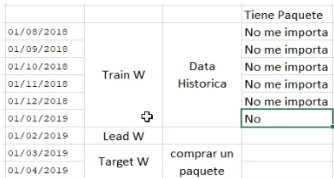

In [9]:
# Clientes del ultimo mes de train
df_last_month_of_train = data[data['Month'] == '2019-01-01'][['client_id', 'Package_Active', 'Month', 'Target']]
df_last_month_of_train.shape

(26503, 4)

In [10]:
# Genero el df de clientes sin conbranding del ultimo mes de train
df_last_month_of_train_no_cobrand = data[(data['Month'] == '2019-01-01') & (data['CreditCard_CoBranding'] == 'No')][['client_id']]
df_last_month_of_train_no_cobrand.shape

(23660, 1)

In [11]:
# Genero el df de clientes sin paquetes activos del ultimo mes de train
df_last_month_of_train_no_package = data[(data['Month'] == '2019-01-01') & (data['Package_Active'] == 'No')][['client_id']]
df_last_month_of_train_no_package.shape

(26026, 1)

In [12]:
# Genero el universo: clientes con 9 meses de datos, sin paquete activo y sin cobranding en 2019-01-01
universe = df_clients_with_nine_month_data.merge(df_last_month_of_train_no_package, how='inner', on='client_id')\
                                        .merge(df_last_month_of_train_no_cobrand, how='inner', on='client_id')\
                                        .drop_duplicates()

print(f"UNIVERSO: {universe.shape}")

UNIVERSO: (23191, 1)


### CU: Getting Target

In [13]:
# Todos los datos del .csv
data.shape

(238615, 77)

In [14]:
# Datos filtrados con el universo
data_universe = data.merge(universe, how='inner', on='client_id')
data_universe.shape

(208719, 77)

In [15]:
data_universe.Month.value_counts()

Month
2018-10-01    23191
2018-09-01    23191
2019-01-01    23191
2018-12-01    23191
2019-02-01    23191
2019-04-01    23191
2018-11-01    23191
2018-08-01    23191
2019-03-01    23191
Name: count, dtype: int64

In [16]:
target_universe = data_universe[(data_universe.Month.isin(['2019-03-01', '2019-04-01'])) & (data_universe.Target == 1)][['client_id']].drop_duplicates()
target_universe.shape

(6823, 1)

In [17]:
target_universe['TGT'] = 1
target_universe.shape

(6823, 2)

In [18]:
target = universe.merge(target_universe, how='left', on='client_id').fillna(0)
target.TGT.value_counts().reset_index()

,TGT,count
0,0.0,16368
1,1.0,6823


In [19]:
total = target.TGT.count()
objetivo = target[target.TGT == 1.0].TGT.count()
obj_porcentaje = round((objetivo/total) * 100, 2)
print(f"TOTAL: {total} - OBJETIVO: {objetivo} ({obj_porcentaje}%)")

TOTAL: 23191 - OBJETIVO: 6823 (29.42%)


# 2. Preprocesamiento y Transformación

In [20]:
# Genero el df de la ventana de entrenamiento
training_window_universe = data_universe[data_universe.Month.isin(['2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'])]
training_window_universe.Month.value_counts().reset_index()

,Month,count
0,2018-10-01,23191
1,2018-09-01,23191
2,2019-01-01,23191
3,2018-12-01,23191
4,2018-11-01,23191
5,2018-08-01,23191


### CU: Find Data Types

In [21]:
training_window_universe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 139146 entries, 0 to 208716
Data columns (total 77 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   client_id                                      139146 non-null  int64  
 1   Target                                         139146 non-null  float64
 2   Month                                          139146 non-null  object 
 3   First_product_dt                               139146 non-null  object 
 4   Last_product_dt                                139146 non-null  object 
 5   CreditCard_Premium                             139146 non-null  object 
 6   CreditCard_Active                              139146 non-null  object 
 7   CreditCard_CoBranding                          139146 non-null  object 
 8   Loan_Active                                    139146 non-null  object 
 9   Mortgage_Active                           

In [22]:
training_window_universe.dtypes.value_counts().reset_index()

,index,count
0,float64,50
1,object,26
2,int64,1


### CU: Find Identity Feature

In [23]:
# Genero los posibles identity features del ultimo mes del training window
identity_features = training_window_universe[training_window_universe.Month == '2019-01-01']\
    [['client_id', 'First_product_dt', 'Last_product_dt', 'Month',
      'CreditCard_Premium', 'CreditCard_Active', 'Loan_Active', 'Mortgage_Active',
      'SavingAccount_Active_ARG_Salary', 'SavingAccount_Active_ARG', 'SavingAccount_Active_DOLLAR',
      'DebitCard_Active', 'Investment_Active',
      'Insurance_Life', 'Insurance_Home', 'Insurance_Accidents', 'Insurance_Mobile', 'Insurance_ATM', 'Insurance_Unemployment',
      'Sex', 'Client_Age_grp', 'Mobile', 'Email', 'Region', 'CreditCard_Product',
      'Operations_Bank', 'Operations_Terminal', 'Operations_HomeBanking', 'Operations_Mobile', 'Operations_Ivr',
      'Operations_Telemarketer', 'Operations_ATM']]

identity_features.shape

(23191, 32)

In [24]:
# Se eliminan los identity features del universo
training_window_universe.drop(['First_product_dt', 'Last_product_dt', 'Month',
      'CreditCard_Premium', 'CreditCard_Active', 'Loan_Active', 'Mortgage_Active',
      'SavingAccount_Active_ARG_Salary', 'SavingAccount_Active_ARG', 'SavingAccount_Active_DOLLAR',
      'DebitCard_Active', 'Investment_Active',
      'Insurance_Life', 'Insurance_Home', 'Insurance_Accidents', 'Insurance_Mobile', 'Insurance_ATM', 'Insurance_Unemployment',
      'Sex', 'Client_Age_grp', 'Mobile', 'Email', 'Region', 'CreditCard_Product',
      'Operations_Bank', 'Operations_Terminal', 'Operations_HomeBanking', 'Operations_Mobile', 'Operations_Ivr',
      'Operations_Telemarketer', 'Operations_ATM'], inplace=True, axis=1)
training_window_universe.shape

/tmp/ipykernel_441795/2601035839.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_window_universe.drop(['First_product_dt', 'Last_product_dt', 'Month',


(139146, 46)

### CU: Find Transform Features

In [25]:
# Ejemplo de transform feature
identity_features.Client_Age_grp.value_counts().reset_index()

,Client_Age_grp,count
0,Entre 40 y 49 años,6563
1,Entre 30 y 39 años,5308
2,Entre 50 y 59 años,5149
3,Entre 60 y 64 años,2122
4,Entre 65 y 69 años,1745
5,Mayor a 70 años,1315
6,Entre 18 y 29 años,989


In [26]:
# Transformo los rangos de edad a valores ordinales
ages_dict = {
    'Entre 18 y 29 años': 1,
    'Entre 30 y 39 años': 2,
    'Entre 40 y 49 años': 3,
    'Entre 50 y 59 años': 4,
    'Entre 60 y 64 años': 5,
    'Entre 65 y 69 años': 6,
    'Mayor a 70 años': 7,
}

identity_features['Client_Age_grp_ordinal'] = identity_features['Client_Age_grp'].map(ages_dict)
identity_features['Client_Age_grp_ordinal'].value_counts().reset_index()

,Client_Age_grp_ordinal,count
0,3,6563
1,2,5308
2,4,5149
3,5,2122
4,6,1745
5,7,1315
6,1,989


In [27]:
# Generacion de nuevas features (suma de features)
identity_features['Active_Insurance'] = np.where(identity_features.Insurance_Life == 'Yes', 1, 0) \
    + np.where(identity_features.Insurance_Home == 'Yes', 1, 0) \
    + np.where(identity_features.Insurance_Accidents == 'Yes', 1, 0) \
    + np.where(identity_features.Insurance_Mobile == 'Yes', 1, 0) \
    + np.where(identity_features.Insurance_ATM == 'Yes', 1, 0) \
    + np.where(identity_features.Insurance_Unemployment == 'Yes', 1, 0)

identity_features['Active_Insurance'].value_counts().reset_index()

,Active_Insurance,count
0,0,23191


In [28]:
identity_features['Active_Products'] = np.where(identity_features.Loan_Active == 'Yes', 1, 0) \
    + np.where(identity_features.CreditCard_Active == 'Yes', 1, 0) \
    + np.where(identity_features.Mortgage_Active == 'Yes', 1, 0) \
    + np.where(identity_features.SavingAccount_Active_ARG == 'Yes', 1, 0) \
    + np.where(identity_features.SavingAccount_Active_DOLLAR == 'Yes', 1, 0) \
    + np.where(identity_features.DebitCard_Active == 'Yes', 1, 0) \
    + np.where(identity_features.Investment_Active == 'Yes', 1, 0) \
    + np.where(identity_features.Active_Insurance > 0, 1, 0)

identity_features['Active_Products'].value_counts().reset_index()


,Active_Products,count
0,1,6628
1,3,6040
2,4,5726
3,2,2680
4,5,1992
5,6,106
6,0,17
7,7,2


In [29]:
# Como ningun cliente tiene seguros activos, no tiene sentido tener este feature
identity_features.drop(['Active_Insurance'], inplace=True, axis=1)

In [30]:
# Transformacion de fechas

# Primero paso fechas de tipo object a fechas de tipo datetime para poder operar
identity_features['First_product_dt'] = pd.to_datetime(identity_features['First_product_dt'])
identity_features['Last_product_dt'] = pd.to_datetime(identity_features['Last_product_dt'])
identity_features['Month'] = pd.to_datetime(identity_features['Month'])

identity_features[['Month']].dtypes

Month    datetime64[ns]
dtype: object

In [31]:
identity_features['Months_From_First_Product'] = (identity_features['Month'] - identity_features['First_product_dt']).dt.days / 30
identity_features['Months_From_First_Product'].value_counts().reset_index()

,Months_From_First_Product,count
0,175.600000,212
1,130.133333,104
2,144.200000,101
3,141.900000,101
4,149.300000,91
...,...,...
3638,126.533333,1
3639,288.200000,1
3640,146.566667,1
3641,222.100000,1


In [32]:
identity_features['Months_From_First_Last_Product'] = (identity_features['Last_product_dt'] - identity_features['First_product_dt']).dt.days / 30
identity_features['Months_From_First_Last_Product'].value_counts().reset_index()

,Months_From_First_Last_Product,count
0,0.000000,5271
1,0.033333,894
2,34.600000,303
3,0.066667,187
4,34.666667,80
...,...,...
4113,122.033333,1
4114,28.166667,1
4115,5.033333,1
4116,169.366667,1


In [33]:
identity_features['Months_From_Last_Product'] = (identity_features['Month'] - identity_features['Last_product_dt']).dt.days / 30
identity_features['Months_From_Last_Product'].value_counts().reset_index()

,Months_From_Last_Product,count
0,1.133333,919
1,-0.100000,601
2,0.433333,565
3,0.166667,564
4,0.633333,548
...,...,...
3098,10.566667,1
3099,117.766667,1
3100,36.166667,1
3101,107.533333,1


In [34]:
identity_features[['First_product_dt', 'Last_product_dt', 'Month', 'Months_From_First_Product', 'Months_From_First_Last_Product', 'Months_From_Last_Product']]

,First_product_dt,Last_product_dt,Month,Months_From_First_Product,Months_From_First_Last_Product,Months_From_Last_Product
2,2016-08-31,2018-12-27,2019-01-01,28.433333,28.266667,0.166667
10,2014-04-29,2017-05-31,2019-01-01,56.933333,37.600000,19.333333
11,2016-01-07,2017-05-24,2019-01-01,36.333333,16.766667,19.566667
15,2017-06-09,2018-08-27,2019-01-01,19.033333,14.800000,4.233333
18,2004-07-30,2004-07-30,2019-01-01,175.600000,0.000000,175.600000
...,...,...,...,...,...,...
208682,2015-12-04,2018-11-02,2019-01-01,37.466667,35.466667,2.000000
208683,2015-03-12,2018-03-02,2019-01-01,46.366667,36.200000,10.166667
208694,2015-06-23,2015-06-23,2019-01-01,42.933333,0.000000,42.933333
208695,2014-04-13,2014-04-13,2019-01-01,57.466667,0.000000,57.466667


In [35]:
# Se cambia los meses con valores negativos a ceros
print(f"Existen meses en negativo: {any(ele < 0 for ele in identity_features['Months_From_Last_Product'])}")

identity_features['Months_From_First_Product'] = np.where(identity_features['Months_From_First_Product'] < 0, 0, identity_features['Months_From_First_Product'])
identity_features['Months_From_First_Last_Product'] = np.where(identity_features['Months_From_First_Last_Product'] < 0, 0, identity_features['Months_From_First_Last_Product'])
identity_features['Months_From_Last_Product'] = np.where(identity_features['Months_From_Last_Product'] < 0, 0, identity_features['Months_From_Last_Product'])

identity_features[['First_product_dt', 'Last_product_dt', 'Month', 'Months_From_First_Product', 'Months_From_First_Last_Product', 'Months_From_Last_Product']]

Existen meses en negativo: True


,First_product_dt,Last_product_dt,Month,Months_From_First_Product,Months_From_First_Last_Product,Months_From_Last_Product
2,2016-08-31,2018-12-27,2019-01-01,28.433333,28.266667,0.166667
10,2014-04-29,2017-05-31,2019-01-01,56.933333,37.600000,19.333333
11,2016-01-07,2017-05-24,2019-01-01,36.333333,16.766667,19.566667
15,2017-06-09,2018-08-27,2019-01-01,19.033333,14.800000,4.233333
18,2004-07-30,2004-07-30,2019-01-01,175.600000,0.000000,175.600000
...,...,...,...,...,...,...
208682,2015-12-04,2018-11-02,2019-01-01,37.466667,35.466667,2.000000
208683,2015-03-12,2018-03-02,2019-01-01,46.366667,36.200000,10.166667
208694,2015-06-23,2015-06-23,2019-01-01,42.933333,0.000000,42.933333
208695,2014-04-13,2014-04-13,2019-01-01,57.466667,0.000000,57.466667


In [36]:
# Se eliminan las fechas como tal
identity_features.drop(['First_product_dt', 'Last_product_dt', 'Month'], inplace=True, axis=1)

In [37]:
# Se agrega la transform feature de Operationes totales
identity_features['Operations_Total'] = identity_features.Operations_Bank + identity_features.Operations_Terminal +\
    identity_features.Operations_HomeBanking + identity_features.Operations_Mobile + identity_features.Operations_Ivr +\
    identity_features.Operations_Telemarketer + identity_features.Operations_ATM
identity_features['Operations_Total'].value_counts().reset_index()

,Operations_Total,count
0,0.0,10192
1,1.0,4186
2,2.0,2324
3,3.0,1291
4,4.0,927
5,5.0,656
6,6.0,479
7,7.0,435
8,8.0,361
9,9.0,317


In [38]:
# Se agrega la transform feature de Canales digitales y fisicos
identity_features['Digital_Channels'] = identity_features.Operations_HomeBanking + identity_features.Operations_Mobile +\
    identity_features.Operations_Ivr + identity_features.Operations_Telemarketer

identity_features['Physical_Channels'] = identity_features.Operations_Bank + identity_features.Operations_Terminal + identity_features.Operations_ATM

identity_features[['Digital_Channels', 'Physical_Channels']].value_counts().reset_index()

,Digital_Channels,Physical_Channels,count
0,0.0,0.0,10192
1,0.0,1.0,2541
2,1.0,0.0,1645
3,2.0,0.0,992
4,0.0,2.0,881
...,...,...,...
285,26.0,3.0,1
286,28.0,3.0,1
287,28.0,5.0,1
288,54.0,2.0,1


In [39]:
# Se agrega la transform feature de HomeBanking vs Mobile
identity_features['Operations_HomeBanking_vs_Mobile'] = np.where(identity_features['Operations_Mobile'] == 0,
                                                       identity_features.Operations_HomeBanking,
                                                       identity_features.Operations_HomeBanking / identity_features.Operations_Mobile)

identity_features['Operations_HomeBanking_vs_Mobile'].value_counts().reset_index()

,Operations_HomeBanking_vs_Mobile,count
0,0.000000,16415
1,1.000000,1939
2,2.000000,1033
3,3.000000,644
4,4.000000,387
...,...,...
211,0.941176,1
212,0.812500,1
213,3.428571,1
214,0.478261,1


### CU: Find Missing Values

In [40]:
identity_features.columns

Index(['client_id', 'CreditCard_Premium', 'CreditCard_Active', 'Loan_Active',
       'Mortgage_Active', 'SavingAccount_Active_ARG_Salary',
       'SavingAccount_Active_ARG', 'SavingAccount_Active_DOLLAR',
       'DebitCard_Active', 'Investment_Active', 'Insurance_Life',
       'Insurance_Home', 'Insurance_Accidents', 'Insurance_Mobile',
       'Insurance_ATM', 'Insurance_Unemployment', 'Sex', 'Client_Age_grp',
       'Mobile', 'Email', 'Region', 'CreditCard_Product', 'Operations_Bank',
       'Operations_Terminal', 'Operations_HomeBanking', 'Operations_Mobile',
       'Operations_Ivr', 'Operations_Telemarketer', 'Operations_ATM',
       'Client_Age_grp_ordinal', 'Active_Products',
       'Months_From_First_Product', 'Months_From_First_Last_Product',
       'Months_From_Last_Product', 'Operations_Total', 'Digital_Channels',
       'Physical_Channels', 'Operations_HomeBanking_vs_Mobile'],
      dtype='object')

In [41]:
# Busco columnas con nulos en los features
identity_features.columns[identity_features.isnull().any()].tolist()

['Region', 'CreditCard_Product']

In [42]:
# Elimino Region
identity_features.drop(['Region'], inplace=True, axis=1)

In [43]:
# Existen tarjetas de creditos activos?
identity_features['CreditCard_Active'].value_counts().reset_index()

,CreditCard_Active,count
0,Yes,15023
1,No,8168


In [44]:
# Como existen CreditCard_Active, tiene que existir CreditCard_Product. Una opcion es traer los datos de otra ventana,
# ya que no es un dato que cambie mucho en el tiempo
data.groupby(['Month', 'CreditCard_Product']).size()

Month       CreditCard_Product
2019-03-01  J55660102XX012         417
            J55660104XX012        8655
            J55660123XX012         388
            J55660124XX012        2491
            J55660202XX012        6032
            J55660702XX012         282
            J55661002XX012          67
2019-04-01  J55660102XX012         417
            J55660104XX012        8643
            J55660123XX012         386
            J55660124XX012        2487
            J55660202XX012        6015
            J55660702XX012         285
            J55661002XX012          71
dtype: int64

In [45]:
cc_product = data[data.Month == '2019-03-01'].groupby(['client_id', 'CreditCard_Product']).size().reset_index()

In [46]:
identity_features.drop(['CreditCard_Product'], inplace=True, axis=1)

In [47]:
identity_features = identity_features.merge(cc_product[['client_id', 'CreditCard_Product']], how='left', on='client_id')
identity_features.groupby(['CreditCard_Active', 'CreditCard_Product']).size()

CreditCard_Active  CreditCard_Product
No                 J55660102XX012           7
                   J55660104XX012         148
                   J55660123XX012           7
                   J55660124XX012          37
                   J55660202XX012         101
                   J55660702XX012          13
                   J55661002XX012           3
Yes                J55660102XX012         402
                   J55660104XX012        8279
                   J55660123XX012           1
                   J55660124XX012          29
                   J55660202XX012        5777
                   J55660702XX012         248
                   J55661002XX012          58
dtype: int64

In [48]:
# No puede existir CreditCard_Product sin CreditCard_Active. Se limpia el dato
identity_features['CreditCard_Product'] = np.where(identity_features.CreditCard_Active == 'No', 'No', identity_features.CreditCard_Product)
identity_features.groupby(['CreditCard_Active', 'CreditCard_Product']).size()

CreditCard_Active  CreditCard_Product
No                 No                    8168
Yes                J55660102XX012         402
                   J55660104XX012        8279
                   J55660123XX012           1
                   J55660124XX012          29
                   J55660202XX012        5777
                   J55660702XX012         248
                   J55661002XX012          58
dtype: int64

In [49]:
#identity_features.columns[identity_features.isnull().any()].tolist()
#identity_features[identity_features.CreditCard_Product.isnull()][['client_id']]

In [50]:
identity_features.CreditCard_Product.value_counts().reset_index()

,CreditCard_Product,count
0,J55660104XX012,8279
1,No,8168
2,J55660202XX012,5777
3,J55660102XX012,402
4,J55660702XX012,248
5,J55661002XX012,58
6,J55660124XX012,29
7,J55660123XX012,1


In [51]:
# Busco nulos en el universo del training window
training_window_universe.columns[training_window_universe.isnull().any()].tolist()

['SavingAccount_Balance_Average']

In [52]:
training_window_universe[training_window_universe.SavingAccount_Balance_Average.isnull()][['client_id', 'SavingAccount_Balance_Average',
                                                                    'SavingAccount_Balance_FirstDate', 'SavingAccount_Balance_LastDate']]

,client_id,SavingAccount_Balance_Average,SavingAccount_Balance_FirstDate,SavingAccount_Balance_LastDate
71262,4473325,NaN,149.56,261.46
71263,4837071,NaN,43.53,10608.05
71265,4525957,NaN,935.82,821.72
208716,6412619,NaN,68.91,83.87


In [53]:
training_window_universe['SavingAccount_Balance_Average'] = np.where(training_window_universe.SavingAccount_Balance_Average.isnull(),
                training_window_universe.SavingAccount_Balance_FirstDate + training_window_universe.SavingAccount_Credits_Amounts - training_window_universe.SavingAccount_Debits_Amounts,
                training_window_universe.SavingAccount_Balance_Average)

training_window_universe.columns[training_window_universe.isnull().any()].tolist()

/tmp/ipykernel_441795/3369753239.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_window_universe['SavingAccount_Balance_Average'] = np.where(training_window_universe.SavingAccount_Balance_Average.isnull(),


[]

### CU: Analyze Outliers

In [54]:
training_window_universe['SavingAccount_Balance_Average'].describe()

count    1.391460e+05
mean     4.094871e+03
std      2.293939e+04
min     -5.665900e+02
25%      0.000000e+00
50%      1.032500e+01
75%      1.473138e+03
max      1.771201e+06
Name: SavingAccount_Balance_Average, dtype: float64

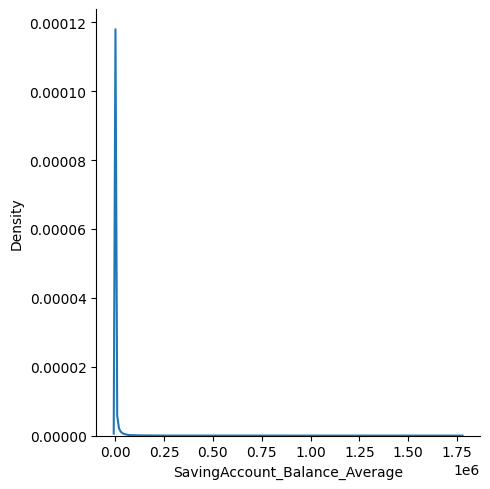

In [55]:
# Grafico: Distribution Plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.displot(training_window_universe['SavingAccount_Balance_Average'], kind='kde')

plt.show()

Text(0, 0.5, 'Factura total')

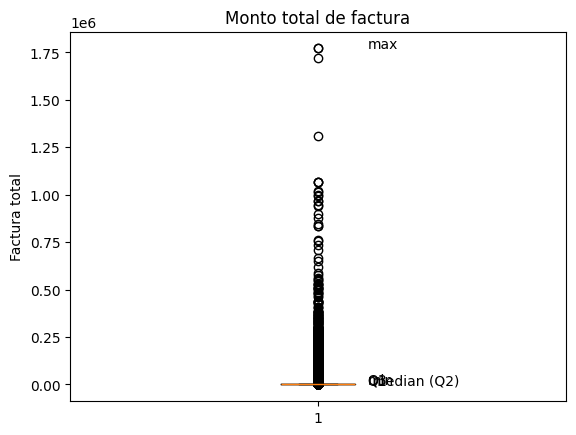

In [56]:
# Grafico: Box Plot
plt.boxplot(training_window_universe['SavingAccount_Balance_Average'])

plt.text(x=1.1, y=training_window_universe['SavingAccount_Balance_Average'].min(), s='min')
plt.text(x=1.1, y=training_window_universe['SavingAccount_Balance_Average'].quantile(0.25), s='Q1')
plt.text(x=1.1, y=training_window_universe['SavingAccount_Balance_Average'].median(), s=' median (Q2)')
plt.text(x=1.1, y=training_window_universe['SavingAccount_Balance_Average'].quantile(0.75), s='Q3')
plt.text(x=1.1, y=training_window_universe['SavingAccount_Balance_Average'].max(), s='max')

plt.title('Monto total de factura')
plt.ylabel('Factura total')

In [57]:
# Elimino los valores menores a 50
SA_Balance_Average_gt_50 = training_window_universe[training_window_universe['SavingAccount_Balance_Average'] > 50]
SA_Balance_Average_gt_50['SavingAccount_Balance_Average'].describe()

count    6.364200e+04
mean     8.950158e+03
std      3.327275e+04
min      5.001000e+01
25%      5.580125e+02
50%      1.779560e+03
75%      5.874622e+03
max      1.771201e+06
Name: SavingAccount_Balance_Average, dtype: float64

In [58]:
# Entre el 75% y el max hay mucha diferencia. Analizo P95, P99 y 3*sigma
p95 = SA_Balance_Average_gt_50['SavingAccount_Balance_Average'].quantile(0.95)
p99 = SA_Balance_Average_gt_50['SavingAccount_Balance_Average'].quantile(0.99)
sigma_3 = 3 * SA_Balance_Average_gt_50['SavingAccount_Balance_Average'].std()

print(f"P95: {p95} - P99: {p99} - 3*sigma: {sigma_3}")

P95: 36826.414999999935 - P99: 122281.20239999995 - 3*sigma: 99818.24947441573


In [59]:
# Elijo el tratamiento de outliers: p95
training_window_universe['SavingAccount_Balance_Average'] = np.where(training_window_universe['SavingAccount_Balance_Average'] < p95,
                                                                     training_window_universe['SavingAccount_Balance_Average'],
                                                                     p95)

training_window_universe['SavingAccount_Balance_Average'].describe()

/tmp/ipykernel_441795/2984753852.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_window_universe['SavingAccount_Balance_Average'] = np.where(training_window_universe['SavingAccount_Balance_Average'] < p95,


count    139146.000000
mean       2692.288490
std        7068.852386
min        -566.590000
25%           0.000000
50%          10.325000
75%        1473.137500
max       36826.415000
Name: SavingAccount_Balance_Average, dtype: float64

### CU: Aggregate Features

In [60]:
training_window_universe.columns

Index(['client_id', 'Target', 'CreditCard_CoBranding', 'Package_Active',
       'SavingAccount_Balance_FirstDate', 'SavingAccount_Balance_LastDate',
       'SavingAccount_Balance_Average', 'SavingAccount_Days_with_use',
       'SavingAccount_Days_with_Credits', 'SavingAccount_Days_with_Debits',
       'SavingAccount_Salary_Payment_Transactions',
       'SavingAccount_Transfer_In_Transactions',
       'SavingAccount_ATM_Extraction_Transactions',
       'SavingAccount_Service_Payment_Transactions',
       'SavingAccount_CreditCard_Payment_Transactions',
       'SavingAccount_Transfer_Out_Transactions',
       'SavingAccount_DebitCard_Spend_Transactions',
       'SavingAccount_Transactions_Transactions',
       'SavingAccount_Credits_Transactions',
       'SavingAccount_Debits_Transactions',
       'SavingAccount_Salary_Payment_Amount',
       'SavingAccount_Transfer_In_Amount',
       'SavingAccount_ATM_Extraction_Amount',
       'SavingAccount_Service_Payment_Amount',
       'SavingAcco

In [61]:
cols_to_aggregate = [x for x in training_window_universe if x not in (['client_id', 'Target', 'Package_Active', 'CreditCard_CoBranding'])]
len(cols_to_aggregate)

42

In [62]:
aggregate_features = training_window_universe.groupby(['client_id'])[cols_to_aggregate].agg([np.sum, np.amax, np.min, np.mean, 
                                                                                            np.median, np.count_nonzero, 'nunique', np.var])


/tmp/ipykernel_441795/626560200.py:1: FutureWarning: The provided callable <function sum at 0x7edeb4563740> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  aggregate_features = training_window_universe.groupby(['client_id'])[cols_to_aggregate].agg([np.sum, np.amax, np.min, np.mean,
/tmp/ipykernel_441795/626560200.py:1: FutureWarning: The provided callable <function min at 0x7edeb45982c0> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  aggregate_features = training_window_universe.groupby(['client_id'])[cols_to_aggregate].agg([np.sum, np.amax, np.min, np.mean,
/tmp/ipykernel_441795/626560200.py:1: FutureWarning: The provided callable <function mean at 0x7edeb4598b80> is currently using SeriesGroupBy.mean. In a future version of pandas, the pro

In [63]:
aggregate_features.columns = ['_'.join(x) for x in np.array(aggregate_features.columns)]
aggregate_features.head(1).T

client_id,1030
SavingAccount_Balance_FirstDate_sum,18847.170
SavingAccount_Balance_FirstDate_amax,8085.910
SavingAccount_Balance_FirstDate_min,141.200
SavingAccount_Balance_FirstDate_mean,3141.195
SavingAccount_Balance_FirstDate_median,2702.885
...,...
Investment_Numbers_mean,0.000
Investment_Numbers_median,0.000
Investment_Numbers_count_nonzero,0.000
Investment_Numbers_nunique,1.000


### CU: Create the Analytic Base Table

In [64]:
ABT = target.merge(identity_features, how='inner', on='client_id')\
    .merge(aggregate_features, how='inner', on='client_id')

ABT.shape

(23191, 374)

# 3. Reducción de dimensionalidad

### CU: Unique Values

In [65]:
# Elimino los features con valores min == max
abt_desc = pd.DataFrame(ABT.describe().T)

min_eq_max = abt_desc[abt_desc['min'] == abt_desc['max']].reset_index()
print("Min == Max: ", min_eq_max.shape)

ABT.drop(min_eq_max['index'], inplace=True, axis=1)
print("ABT: ", ABT.shape)

Min == Max:  (0, 9)
ABT:  (23191, 374)


### CU: Correlation Matrix

In [66]:
# Ejemplo de matriz de correlacion
corr = ABT[['SavingAccount_ATM_Extraction_Transactions_sum',
 'SavingAccount_ATM_Extraction_Transactions_amax',
 'SavingAccount_ATM_Extraction_Transactions_min',
 'SavingAccount_ATM_Extraction_Transactions_mean',
 'SavingAccount_ATM_Extraction_Transactions_median',
 'SavingAccount_ATM_Extraction_Transactions_count_nonzero',
 'SavingAccount_ATM_Extraction_Transactions_nunique',
 'SavingAccount_ATM_Extraction_Transactions_var',]].corr()

corr

,SavingAccount_ATM_Extraction_Transactions_sum,SavingAccount_ATM_Extraction_Transactions_amax,SavingAccount_ATM_Extraction_Transactions_min,SavingAccount_ATM_Extraction_Transactions_mean,SavingAccount_ATM_Extraction_Transactions_median,SavingAccount_ATM_Extraction_Transactions_count_nonzero,SavingAccount_ATM_Extraction_Transactions_nunique,SavingAccount_ATM_Extraction_Transactions_var
SavingAccount_ATM_Extraction_Transactions_sum,1.000000,0.952212,0.882861,1.000000,0.986484,0.806449,0.802438,0.665879
SavingAccount_ATM_Extraction_Transactions_amax,0.952212,1.000000,0.750299,0.952212,0.902447,0.830317,0.861358,0.789657
SavingAccount_ATM_Extraction_Transactions_min,0.882861,0.750299,1.000000,0.882861,0.881179,0.611242,0.550659,0.384918
SavingAccount_ATM_Extraction_Transactions_mean,1.000000,0.952212,0.882861,1.000000,0.986484,0.806449,0.802438,0.665879
SavingAccount_ATM_Extraction_Transactions_median,0.986484,0.902447,0.881179,0.986484,1.000000,0.779241,0.765660,0.600663
SavingAccount_ATM_Extraction_Transactions_count_nonzero,0.806449,0.830317,0.611242,0.806449,0.779241,1.000000,0.945210,0.477569
SavingAccount_ATM_Extraction_Transactions_nunique,0.802438,0.861358,0.550659,0.802438,0.765660,0.945210,1.000000,0.548356
SavingAccount_ATM_Extraction_Transactions_var,0.665879,0.789657,0.384918,0.665879,0.600663,0.477569,0.548356,1.000000


<Axes: >

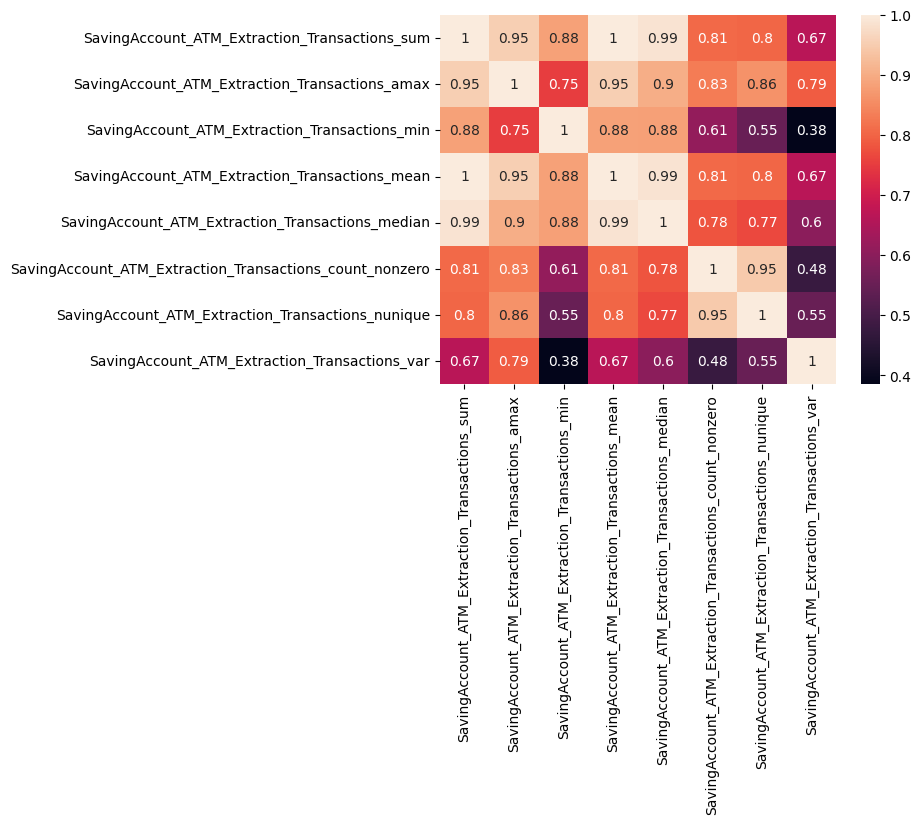

In [67]:
sns.heatmap(corr, annot=True)

In [68]:
# Elimino de la ABT las columnas que tengan una correlacion mayor a 0.85
abt_corr = ABT.drop(['client_id',
 'TGT',
 'CreditCard_Premium',
 'CreditCard_Active',
 'Loan_Active',
 'Mortgage_Active',
 'SavingAccount_Active_ARG_Salary',
 'SavingAccount_Active_ARG',
 'SavingAccount_Active_DOLLAR',
 'DebitCard_Active',
 'Investment_Active',
 'Insurance_Life',
 'Insurance_Home',
 'Insurance_Accidents',
 'Insurance_Mobile',
 'Insurance_ATM',
 'Insurance_Unemployment',
 'Sex',
 'Client_Age_grp',
 'Mobile',
 'Email',
 'CreditCard_Product'], axis=1).corr().abs()

upper_abt_corr = abt_corr.where(np.triu(np.ones(abt_corr.shape), k=1).astype(np.bool)).fillna(0)

corr_gt_85 = [col for col in upper_abt_corr.columns if any(upper_abt_corr[col] > 0.85)]

#print(corr_gt_85)

ABT.drop(corr_gt_85, inplace=True, axis=1)
ABT.shape

(23191, 141)

### CU: PCA (Opcional)

In [69]:
cols = [x for x in ABT.columns if x.startswith('CreditCard_Spending')]
cols

['CreditCard_Spending_1_Installment_sum',
 'CreditCard_Spending_1_Installment_min',
 'CreditCard_Spending_1_Installment_count_nonzero',
 'CreditCard_Spending_Installments_sum',
 'CreditCard_Spending_Installments_var',
 'CreditCard_Spending_CrossBoarder_min',
 'CreditCard_Spending_Aut_Debits_sum',
 'CreditCard_Spending_Aut_Debits_count_nonzero',
 'CreditCard_Spending_Aut_Debits_nunique',
 'CreditCard_Spending_Aut_Debits_var']

In [70]:
# Paso 1: Estandarizar
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = scaler.fit_transform(ABT[cols]) # entrena y transforma las columnas de ABT

df_data_scaled = pd.DataFrame(data_scaled, columns=ABT[cols].columns)

data_scaled.shape

(23191, 10)

In [71]:
# Paso 2: Componentes principales
from sklearn.decomposition import PCA

n = df_data_scaled.shape[1]

pca = PCA(n_components=n, random_state=1)
df_pca = pd.DataFrame(pca.fit_transform(df_data_scaled))

Text(0, 0.5, 'Varianza acumulada')

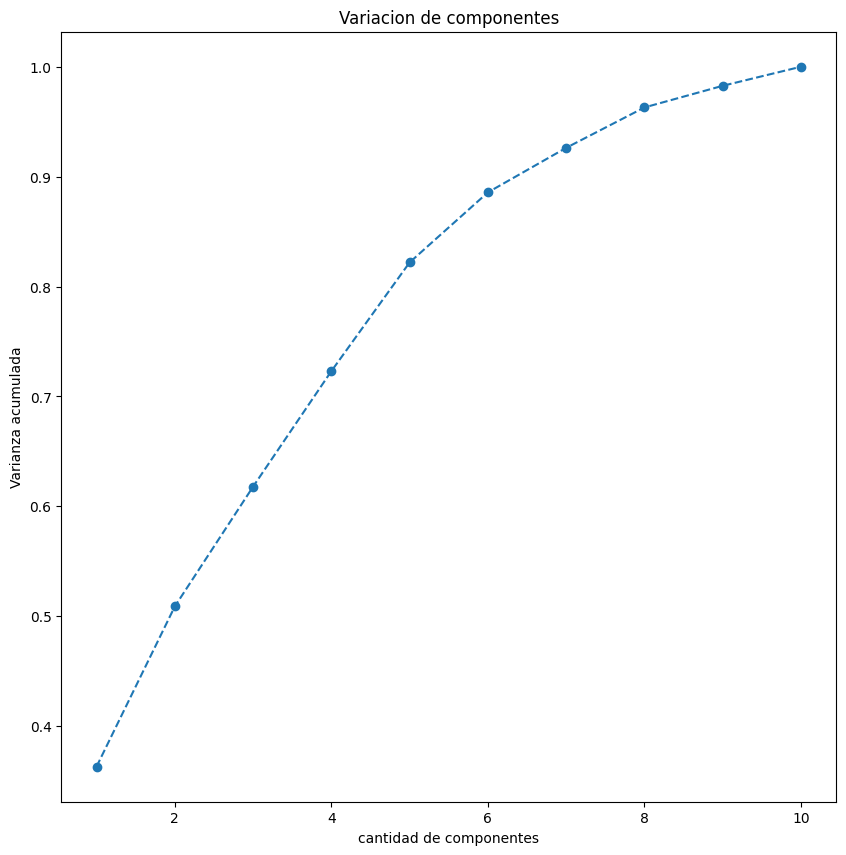

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.plot(range(1, n + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title("Variacion de componentes")
plt.xlabel("cantidad de componentes")
plt.ylabel("Varianza acumulada")

### CU: Get the most important features

In [87]:
# Descarto los features categoricos
ABT_Model = ABT.drop([
 'CreditCard_Premium',
 'CreditCard_Active',
 'Loan_Active',
 'Mortgage_Active',
 'SavingAccount_Active_ARG_Salary',
 'SavingAccount_Active_ARG',
 'SavingAccount_Active_DOLLAR',
 'DebitCard_Active',
 'Investment_Active',
 'Insurance_Life',
 'Insurance_Home',
 'Insurance_Accidents',
 'Insurance_Mobile',
 'Insurance_ATM',
 'Insurance_Unemployment',
 'Sex',
 'Client_Age_grp',
 'Mobile',
 'Email',
 'CreditCard_Product'], axis=1)
ABT_Model.shape

(23191, 121)

In [98]:
# Estandarizacion
cols = [x for x in ABT_Model.columns if (x != 'client_id') and (x != 'TGT')]

scaler = StandardScaler(copy=True)
scaler.fit(ABT_Model[cols])

std_transform = scaler.transform(ABT_Model[cols])
std_transform = pd.DataFrame(std_transform, columns=cols, index=ABT_Model.index)

ABT_Model.drop(cols, inplace=True, axis=1)
ABT_Model = pd.concat((ABT_Model, std_transform), axis=1, sort=False)

ABT_Model.head(10)

,client_id,TGT,Operations_Bank,Operations_Terminal,Operations_HomeBanking,Operations_Mobile,Operations_Ivr,Operations_Telemarketer,Operations_ATM,Client_Age_grp_ordinal,...,CreditCard_Payment_Web_var,CreditCard_Payment_ATM_sum,CreditCard_Payment_ATM_min,CreditCard_Payment_TAS_sum,CreditCard_Payment_TAS_min,CreditCard_Payment_TAS_var,Investment_Numbers_sum,Investment_Numbers_count_nonzero,Investment_Numbers_nunique,Investment_Numbers_var
0,1030,0.0,-0.27226,-0.414801,-0.409126,0.077907,-0.16565,-0.243691,-0.203993,-1.022891,...,-0.254769,-0.219664,-0.123689,-0.328045,-0.174977,-0.240754,-0.175496,-0.243425,-0.215360,-0.066961
1,1094,0.0,-0.27226,-0.414801,-0.409126,-0.271560,-0.16565,-0.243691,-0.203993,-1.022891,...,-0.254769,-0.219664,-0.123689,-0.328045,-0.174977,-0.240754,-0.175496,-0.243425,-0.215360,-0.066961
2,1553,0.0,-0.27226,-0.414801,-0.409126,-0.271560,-0.16565,-0.243691,-0.203993,-1.022891,...,-0.254769,-0.219664,-0.123689,-0.328045,-0.174977,-0.240754,-0.175496,-0.243425,-0.215360,-0.066961
3,1590,0.0,-0.27226,-0.414801,-0.409126,-0.271560,-0.16565,-0.243691,-0.203993,0.302612,...,-0.254769,-0.219664,-0.123689,-0.328045,-0.174977,-0.240754,-0.175496,-0.243425,-0.215360,-0.066961
4,1948,0.0,-0.27226,-0.414801,-0.069491,-0.271560,-0.16565,-0.243691,-0.203993,0.302612,...,-0.254769,-0.219664,-0.123689,-0.328045,-0.174977,-0.240754,-0.175496,-0.243425,-0.215360,-0.066961
5,2110,1.0,-0.27226,0.833370,-0.409126,-0.271560,-0.16565,-0.243691,-0.203993,1.628115,...,-0.254769,-0.219664,-0.123689,-0.328045,-0.174977,-0.240754,-0.175496,-0.243425,-0.215360,-0.066961
6,2498,0.0,-0.27226,-0.414801,-0.409126,-0.271560,-0.16565,-0.243691,-0.203993,2.290867,...,-0.254769,-0.219664,-0.123689,-0.328045,-0.174977,-0.240754,-0.175496,-0.243425,-0.215360,-0.066961
7,2556,0.0,-0.27226,-0.414801,0.609778,-0.271560,-0.16565,-0.243691,-0.203993,2.290867,...,-0.254769,-0.219664,-0.123689,-0.328045,-0.174977,-0.240754,1.879194,4.142948,2.755739,0.258948
8,3244,0.0,-0.27226,-0.414801,-0.409126,-0.271560,-0.16565,-0.243691,-0.203993,-0.360139,...,-0.254769,-0.219664,-0.123689,-0.328045,-0.174977,-0.240754,-0.175496,-0.243425,-0.215360,-0.066961
9,3476,0.0,-0.27226,-0.414801,-0.409126,-0.271560,-0.16565,-0.243691,-0.203993,-0.360139,...,-0.254769,-0.219664,-0.123689,-0.328045,-0.174977,-0.240754,-0.175496,-0.243425,-0.215360,-0.066961


### Graficos

In [ ]:
# Abran el archivo graficos_v2.py y cambien la ruta de los directorios de la funcion Graficar_Variables2

# Para importar la libreria
# %run ./Graficos_v2.py 

# Para que funcione tienen que tener un campo idx y un campo TGT (TGT es el target 1 o 0)
# ABT_Model['idx'] = ABT_Model['client_id']
# ABT['idx'] = ABT['client_id']

# Crear el pdf de las variables que estan en vars
#vars = ['idx', 'TGT', 'CreditCard_Total_Spending_var16_0']
#Graficar_Variables2(ABT[vars], [], 'TGT')